In [1]:
import numpy as np
from scipy import *
import matplotlib.pyplot as plt
import time
import random
import math
import pandas as pd
import matplotlib
import itertools

# Function Defining Section

In [8]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [9]:
def InitiateShops(Num,Price_limit,Quality_Range,Capital,CostAtQuality):
    quality = [random.randint(*Quality_Range) for x in range(Num)]
    price = [random.randint(CostAtQuality[x],Price_limit) for x in quality]
    revenue = [0 for x in range(Num)]
    capital = [Capital for x in range(Num)]
    profit = [revenue[x]-capital[x] for x in range(Num)]
    products = [math.floor(capital[i]/CostAtQuality[x]) for i,x in enumerate(quality)]
    return [products,price,quality,revenue,capital,profit]
 
def InitiateUnifiedShops(Num,Price_Range,Quality_Range,Capital,CostAtQuality): #จะมีปรับปรุง
    price = [Price_Range[0] + math.ceil((x/Num)*(Price_Range[1]-Price_Range[0])) for x in range(Num)]
    quality = [Quality_Range[0] + math.ceil((x/Num)*(Quality_Range[1]-Quality_Range[0])) for x in range(Num)]
    revenue = [0 for x in range(Num)]
    capital = [Capital for x in range(Num)]
    products = [math.floor(capital[i]/CostAtQuality[x]) for i,x in enumerate(quality)]
    profit = [revenue[x]-capital[x] for x in range(Num)]
    return [products,price,quality,revenue,capital,profit]

def InitiateFocusedShop(Shop_List_input,price,quality,capital,CostAtQuality):
    Shop_List = [list(x) for x in Shop_List_input]
    Shop_List[0].append(math.floor(capital/CostAtQuality[quality]))
    Shop_List[1].append(price)
    Shop_List[2].append(quality)
    Shop_List[3].append(0)
    Shop_List[4].append(capital)
    Shop_List[5].append(0-capital)
    return Shop_List

def ExperimentShop(Shop_List_input,price,quality,capital,CostAtQuality):
    Shop_List = [list(x) for x in Shop_List_input]
    Shop_List[0].insert(0,math.floor(capital/CostAtQuality[quality]))
    Shop_List[1].insert(0,price)
    Shop_List[2].insert(0,quality)
    Shop_List[3].insert(0,0)
    Shop_List[4].insert(0,capital)
    Shop_List[5].insert(0,0-capital)
    return Shop_List

def AgentMaker(price,quality,capital,CostAtQuality):
    Output = []
    Output.append(math.floor(capital/CostAtQuality[quality]))
    Output.append(price)
    Output.append(quality)
    Output.append(0)
    Output.append(capital)
    Output.append(0-capital)
    return Output
    
def InitiateCustomer(Num,Wants_Range,Price_Range,Quality_Range,a_range = [0,1] ): #a*price + b*quality = Compatibility point
    product_wanted = [random.randint(*Wants_Range) for x in range(Num)]
    price_wanted = [random.randint(*Price_Range)*product_wanted[x] for x in range(Num)]
    quality_wanted = [random.randint(*Quality_Range) for x in range(Num)]
    ab = []
    for x in range(Num):    
        a = random.uniform(*a_range)
        b = 1-a
        AnB = [a,b]
        ab.append(AnB)
    return [product_wanted,price_wanted,quality_wanted,ab]

def FindShop(Index,Shop_List,Customer_List):
    product_wanted = Customer_List[0][Index]
    price_wanted = Customer_List[1][Index]
    quality_wanted = Customer_List[2][Index]
    a = Customer_List[3][Index][0]
    b = Customer_List[3][Index][1]
    all_price = [price for price in Shop_List[1]]
    Mean_Price = np.sum(all_price)/len(all_price)
    all_Ql = [ql for ql in Shop_List[2]]
    Mean_Ql = np.sum(all_Ql)/len(all_Ql)
    Selected = []
    for index,price in enumerate(Shop_List[1]):
        if price_wanted >= price*product_wanted:
            if Shop_List[0][index] >= product_wanted:
                Selected.append(index)
            else:
                continue
        else:
            continue
    if len(Selected) == 0:
        return None
    Compat_price = [(math.log(sigmoid((Shop_List[1][z]-Mean_Price)/Mean_Price),a)\
                     +math.log((-1)*sigmoid((Shop_List[2][z]-Mean_Ql)/Mean_Ql)+1,b)) for z in Selected]
    fake_index = Compat_price.index(max(Compat_price))
    Shop_to_buy_index = Selected[fake_index]
    
    return Shop_to_buy_index 

def Buying(Customer_Index,Shop_Index,Shop_List,Customer_List):
    product_wanted = Customer_List[0][Customer_Index]
    price_wanted = Customer_List[1][Customer_Index]
    quality_wanted = Customer_List[2][Customer_Index]
    Shop_List[0][Shop_Index] = Shop_List[0][Shop_Index] - product_wanted
    Shop_List[3][Shop_Index] = Shop_List[3][Shop_Index] + product_wanted * Shop_List[1][Shop_Index]
    Shop_List[5][Shop_Index] = Shop_List[5][Shop_Index] + product_wanted * Shop_List[1][Shop_Index]
    
def Simulate(Shop_List,Customer_List):
    for Customer_Index in range(len(Customer_List[0])):
        Shop_to_buy_index = FindShop(Customer_Index,Shop_List,Customer_List)
        if Shop_to_buy_index is None :
            continue
        Buying(Customer_Index,Shop_to_buy_index,Shop_List,Customer_List)

def Select(Pt_List,n):
    numbers = np.array(Pt_List)
    idx = np.argpartition(numbers, -n)[-n:]
    indices = idx[np.argsort((-numbers)[idx])]
    return indices

03 Method

In [10]:
class Optimization:
  def __init__(self,distribution_num,parameter_num,param_limit,param_lr):
    self.n = distribution_num
    self.np = parameter_num
    self.lim = param_limit #2d list [[,],[,]]
    self.param_lr = param_lr

  def Initiate(self):
    param_init = []
    for i,limit in enumerate(self.lim):
      if self.n[i] == 1:
        a = []
        b = limit[1]-limit[0]/2
        a.append(limit[0]+b)
      else:
        a = []
        b = (limit[1]-limit[0])/((self.n[i]-2)+1)
        for i in range(self.n[i]):
            a.append(limit[0]+(i*b))
      param_init.append(a)
    p = itertools.product(*param_init)
    output = [list(i) for i in p]
    return output

  def Breed(self,init_coor,lr_indices):
    lr = self.param_lr
    list_a = []
    for coor in init_coor:
      list_b = []  
      for i,point in enumerate(coor):
        list_c = []
        if point+lr[i][lr_indices] <= self.lim[i][1]:
          list_c.append(point+lr[i][lr_indices])
        list_c.append(point+0)
        if point-lr[i][lr_indices] >= self.lim[i][0]:
          list_c.append(point-lr[i][lr_indices])
        list_b.append(list_c)
      list_a.append(list_b)
    output = []
    for cell in list_a:
      p = itertools.product(*cell)
      result = [list(i) for i in p]
      output.append(result)
    
    return output


# Environment Defining Section


In [11]:
Customer_Env = []
Shop_Env = []

random.seed(1000)

env_prob = [1/9 for x in range(9)]

Capital_THEM = [1500 for x in range(9)]    
CostAtQuality = [[math.ceil((x+1)*5+x**1.65) for x in range(10+1)] for i in range(len(Capital_THEM))]
price_limit = [125 for i in range(len(Capital_THEM))]       
Ql_range = [[4,9],[7,10],[8,10],[0,10],[0,10],[3,8],[1,5],[3,9],[0,3]]     
Shop_Number = [10 for x in range(len(Capital_THEM))] 

for i in range(len(Capital_THEM)):
    Shop_Env.append(InitiateShops(Shop_Number[i],price_limit[i],Ql_range[i],Capital_THEM[i],CostAtQuality[i]))
 

Customer_Num = [25 for x in range(len(Capital_THEM))]        
Want_Range = [[1,3] for i in range(len(Customer_Num))]      
Budget_Range = [[125,126] for i in range(len(Customer_Num))] 
Quality_Range = [[1,10] for i in range(len(Customer_Num))]   
a_rand_range = [[0,1],[0,0.1],[0,1],[0,0.3],[0,1],[0,0.5],[0,1],[0.3,1],[0,1]]    
for i in range(len(Customer_Num)):
    Customer_Env.append(InitiateCustomer(Customer_Num[i],Want_Range[i],Budget_Range[i],Quality_Range[i],a_range = a_rand_range[i]))

Capital = 500

# Each Individual Environment Exploring (Brute Force)

In [ ]:
brute_PQL_history = []
brute_Profit_history = []
time_history = []
for indices in range(len(Shop_Env)):
    brute_Profit_result=[]
    brute_price_limit = Budget_Range[indices][1]
    price_step = 0.1
    brute_quality_limit = 10
    quality_step = 1    
    brute_price_list  = []
    brute_quality_list = []
    price = 0
    quality = 0
    while True:
        brute_price_list.append(round(price,1))
        price += price_step 
        if price>brute_price_limit:
            break
    while True:
        brute_quality_list.append(quality)
        quality += quality_step 
        if quality>brute_quality_limit:
            break
    p = itertools.product(brute_price_list,brute_quality_list)
    brute_PQL_list = [list(i) for i in p]
    brute_PQL_history.append(brute_PQL_list)
    print(f"Environment {indices+1} is being explored with {len(brute_PQL_list)} combinations")
    start = time.time()
    for index,parameter in enumerate(brute_PQL_list):
        
        price = parameter[0]
        quality = round(parameter[1])
        Shop_List_Inloop = list(InitiateFocusedShop(Shop_Env[indices],price,quality,Capital,CostAtQuality[indices]))

        Simulate(Shop_List_Inloop,Customer_Env[indices])

        brute_Profit_result.append(Shop_List_Inloop[5][-1])
        
        if index % 2000 == 0:
            print(f"Index {index} Finished")
    brute_Profit_history.append(brute_Profit_result)
    end = time.time()
    time_history.append(end-start)
    print(f"Environment {indices+1} Finished with {end-start} seconds taken")
    max_value = max(brute_Profit_result)
    max_index = brute_Profit_result.index(max_value)
    print(f"Max profit of Environment {indices+1} is {max_value} with price = {brute_PQL_list[max_index][0]} and quality = {brute_PQL_list[max_index][1]}\n")


Environment 1 is being explored with 13871 combinations
Index 0 Finished
Index 2000 Finished
Index 4000 Finished
Index 6000 Finished
Index 8000 Finished
Index 10000 Finished
Index 12000 Finished
Environment 1 Finished with 13.744608402252197 seconds taken
Max profit of Environment 1 is 777.5 with price = 51.1 and quality = 2

Environment 2 is being explored with 13871 combinations
Index 0 Finished
Index 2000 Finished
Index 4000 Finished
Index 6000 Finished
Index 8000 Finished
Index 10000 Finished
Index 12000 Finished
Environment 2 Finished with 13.089884996414185 seconds taken
Max profit of Environment 2 is 84.50000000000006 with price = 116.9 and quality = 10

Environment 3 is being explored with 13871 combinations
Index 0 Finished
Index 2000 Finished
Index 4000 Finished
Index 6000 Finished
Index 8000 Finished
Index 10000 Finished
Index 12000 Finished
Environment 3 Finished with 13.259099006652832 seconds taken
Max profit of Environment 3 is 877.5999999999998 with price = 65.6 and qua

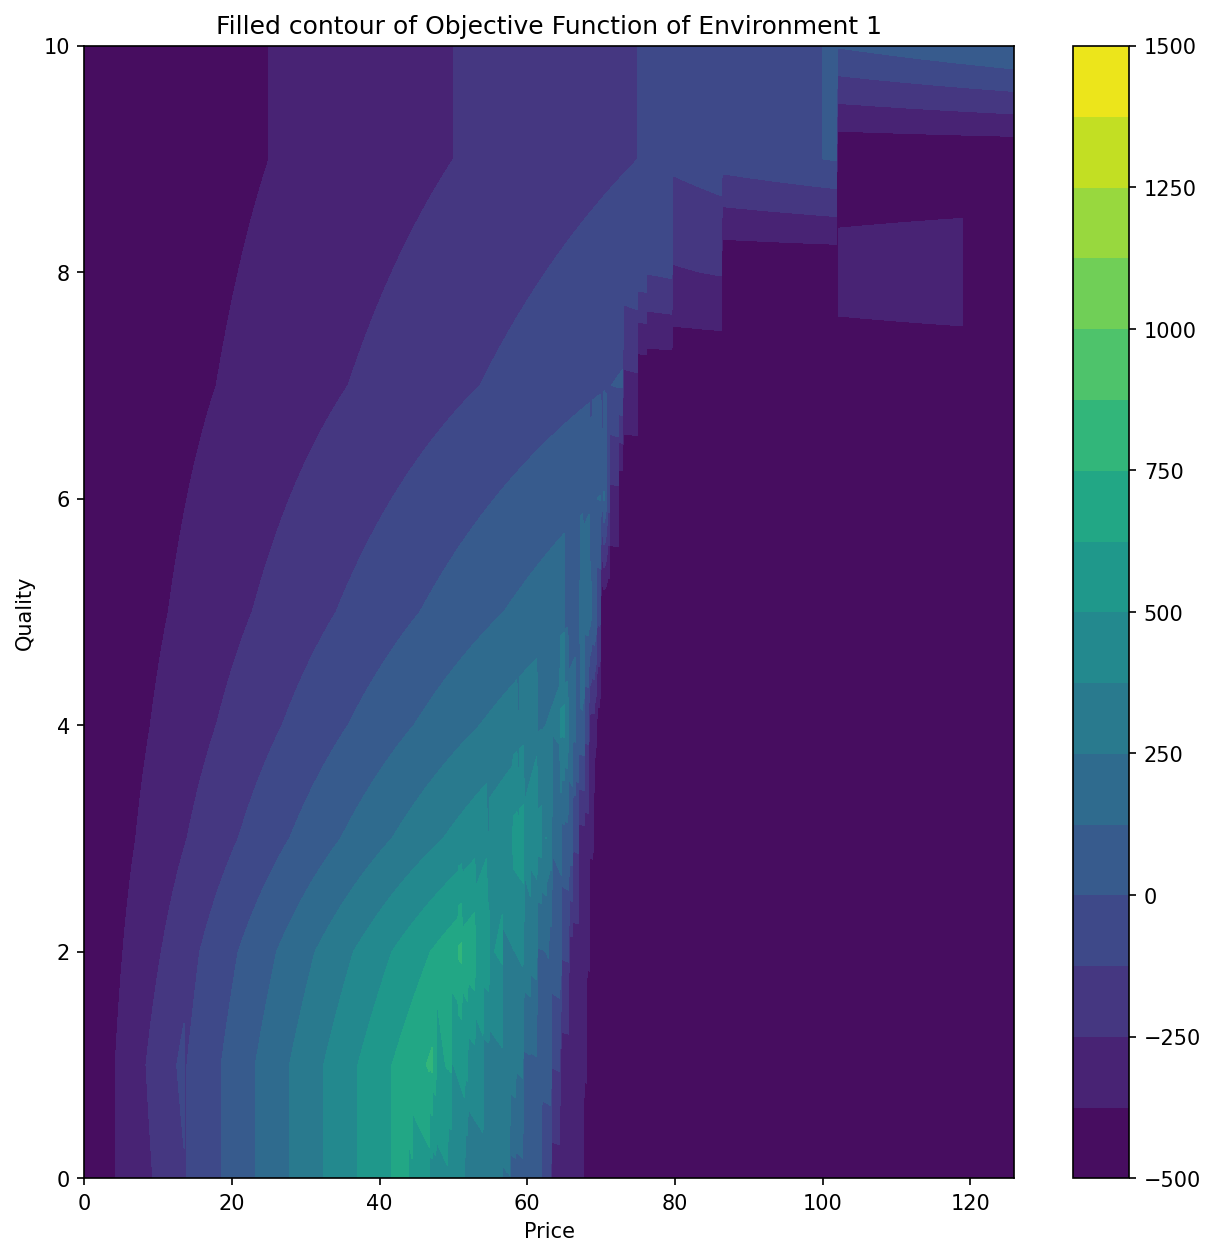

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


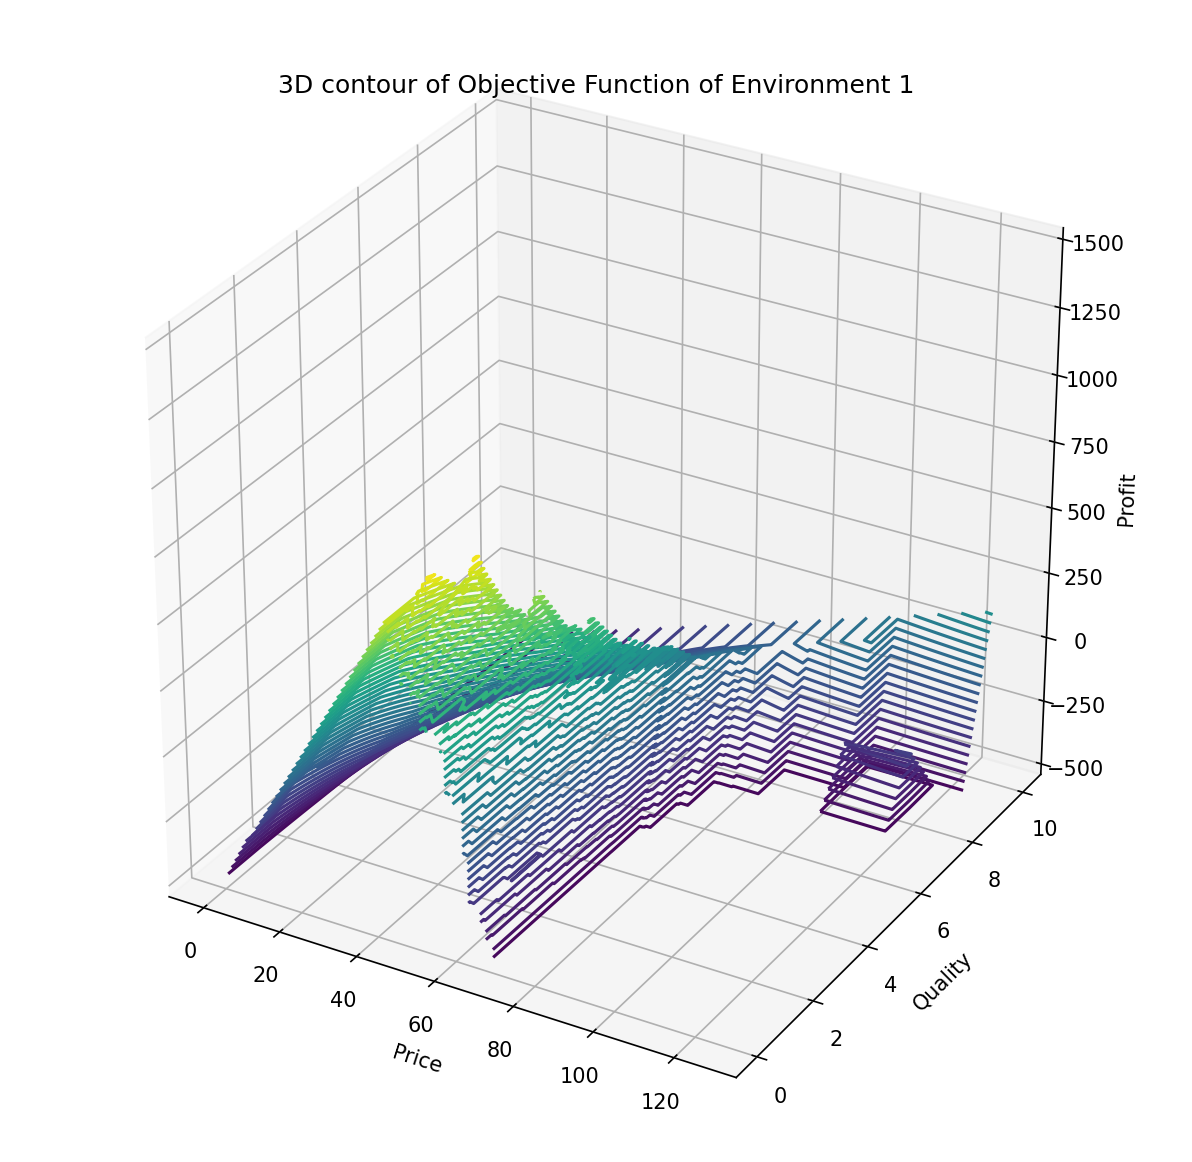

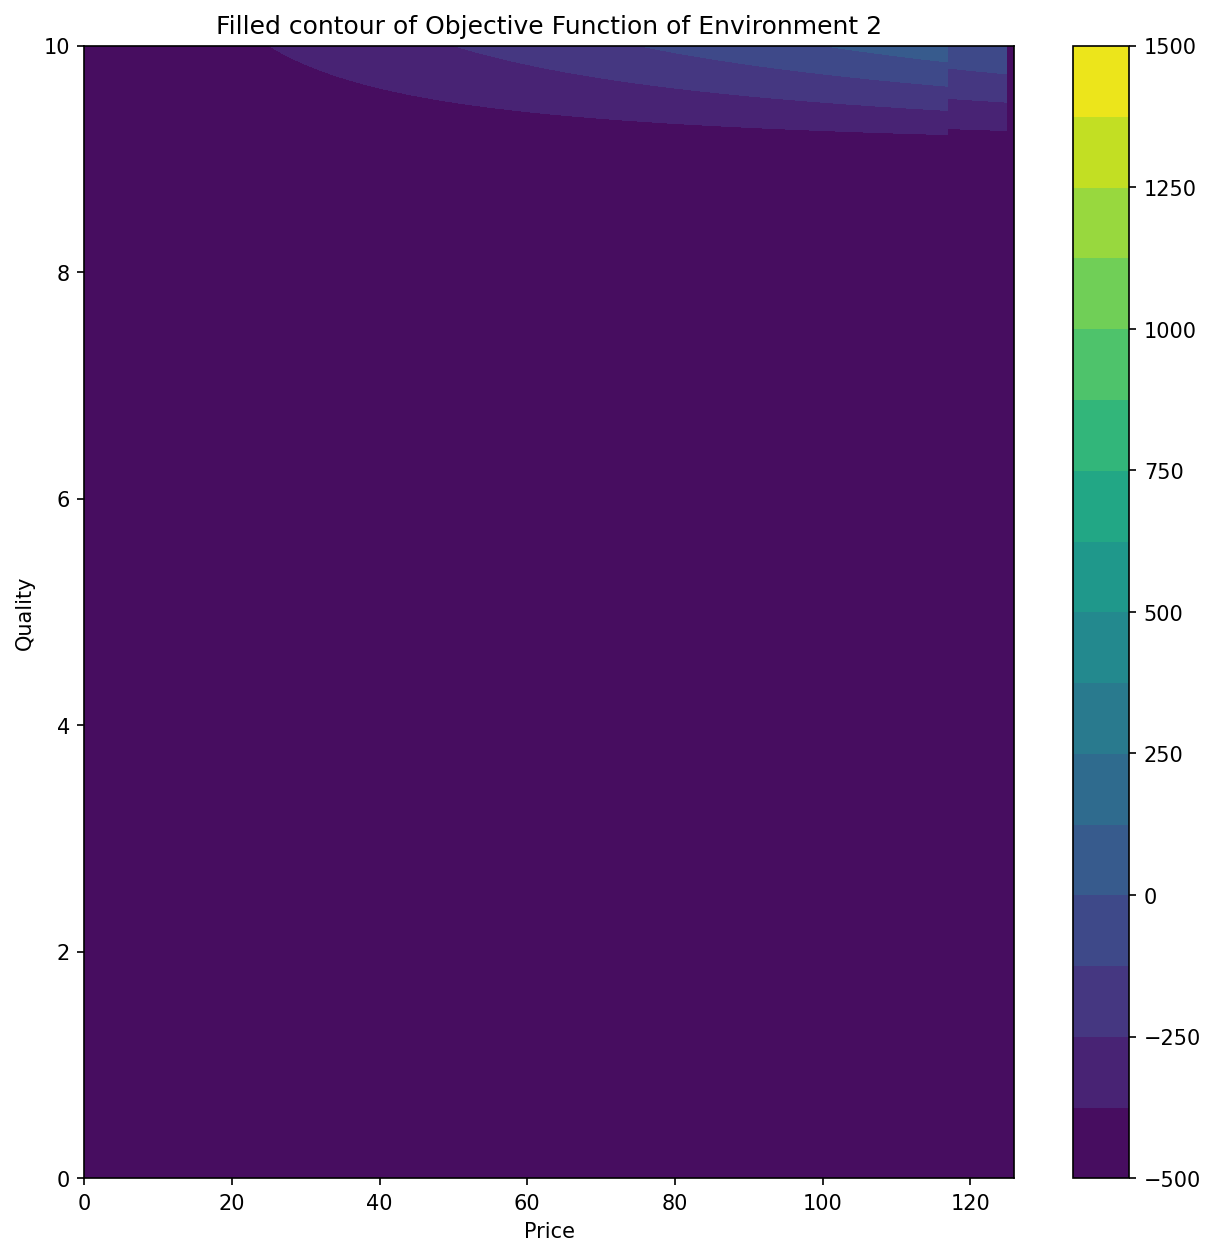

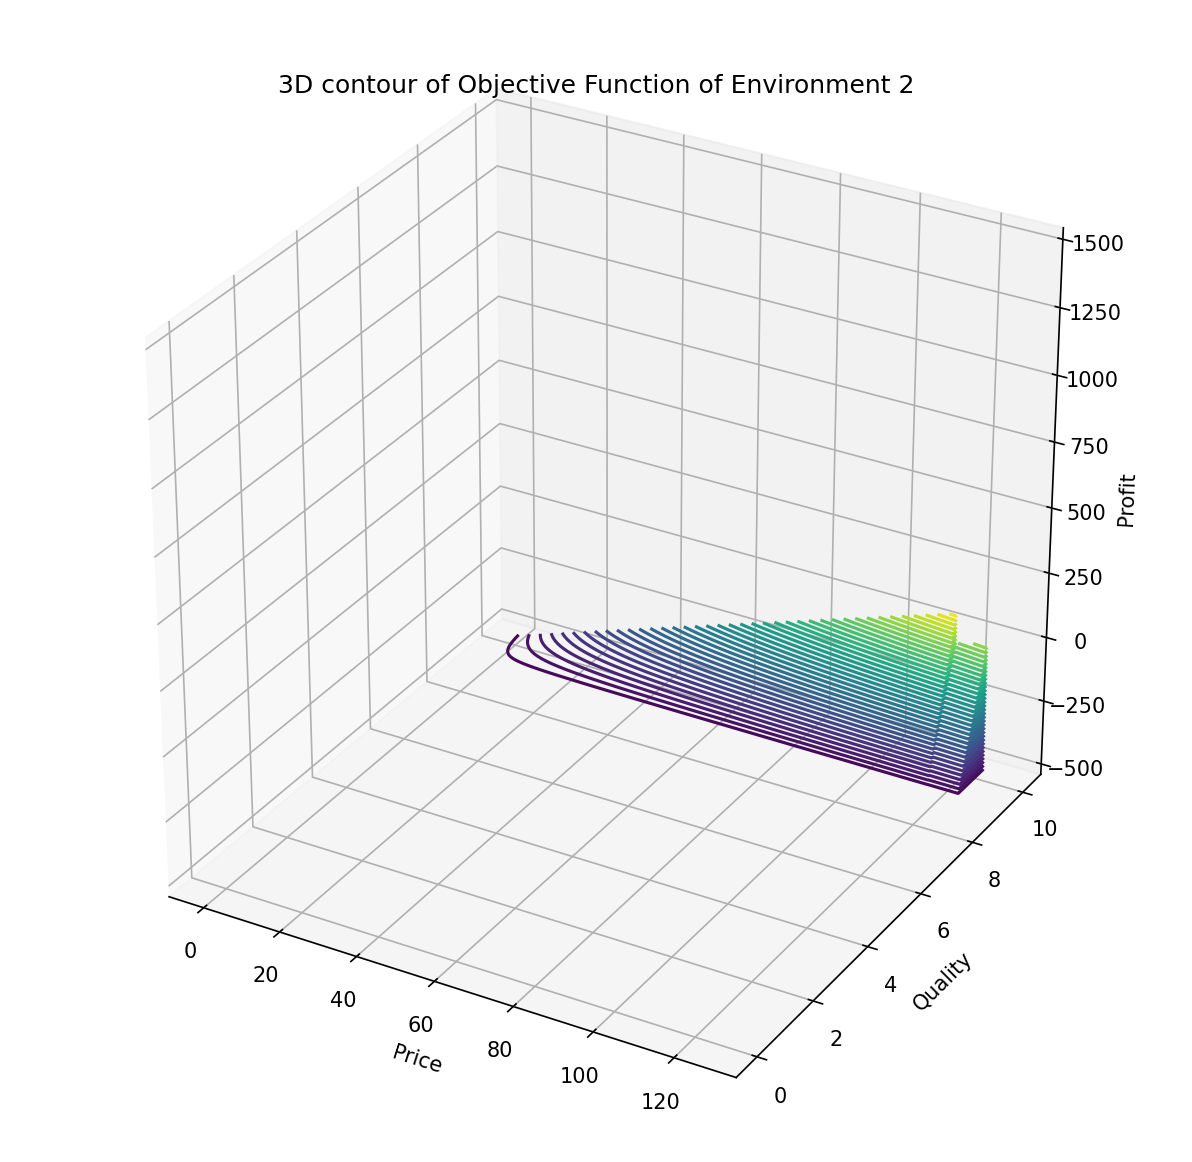

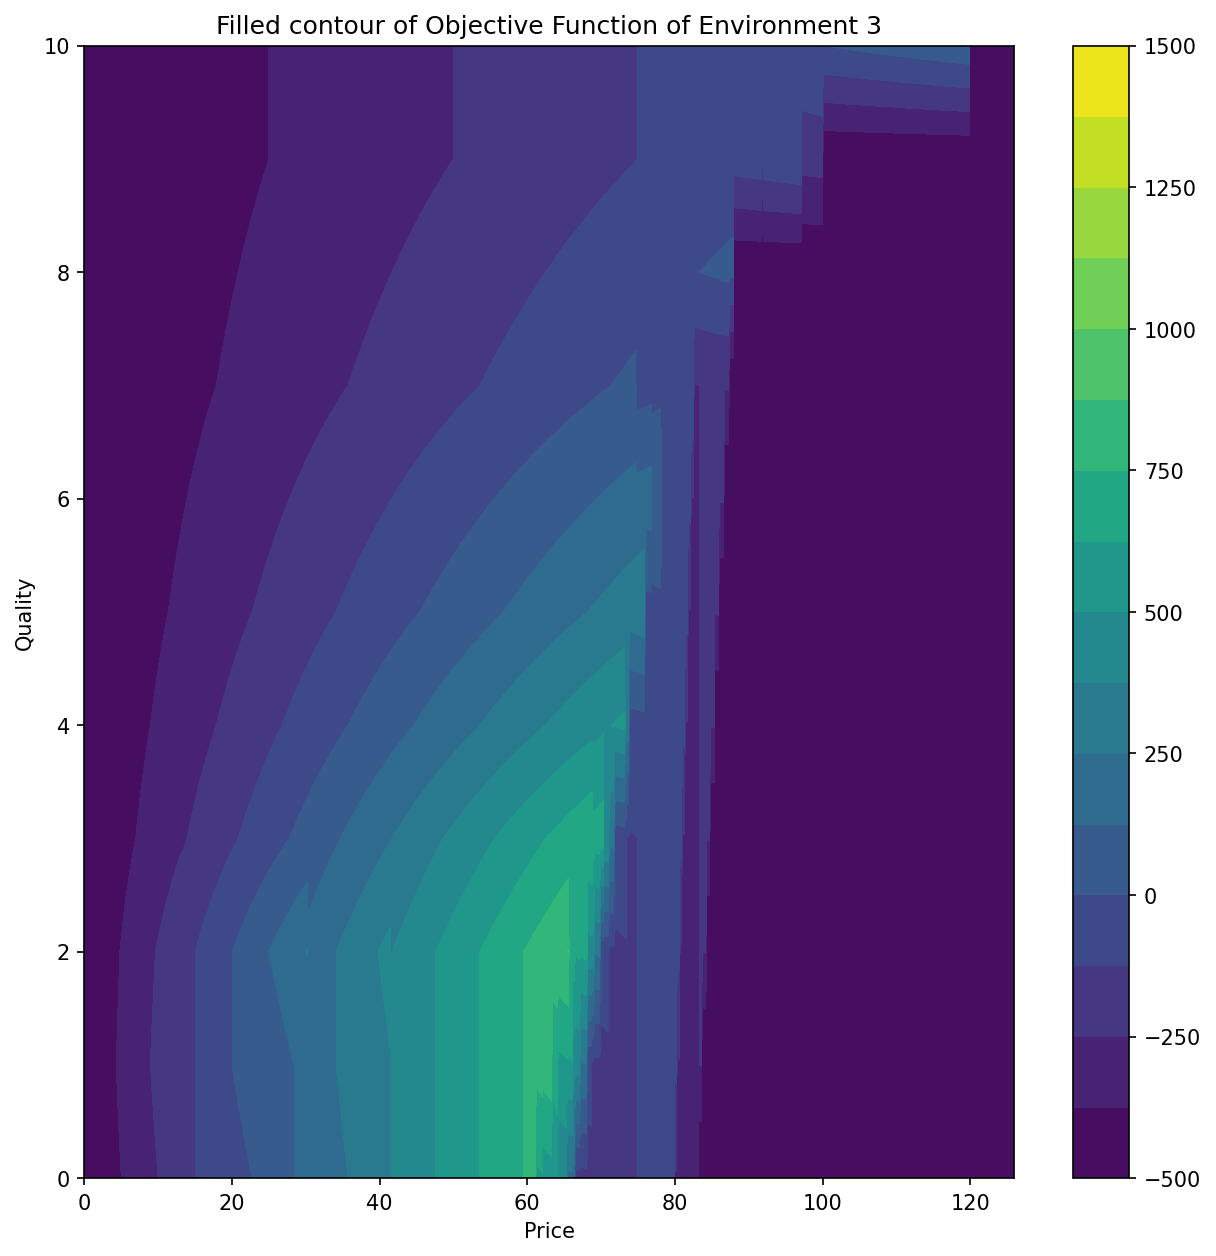

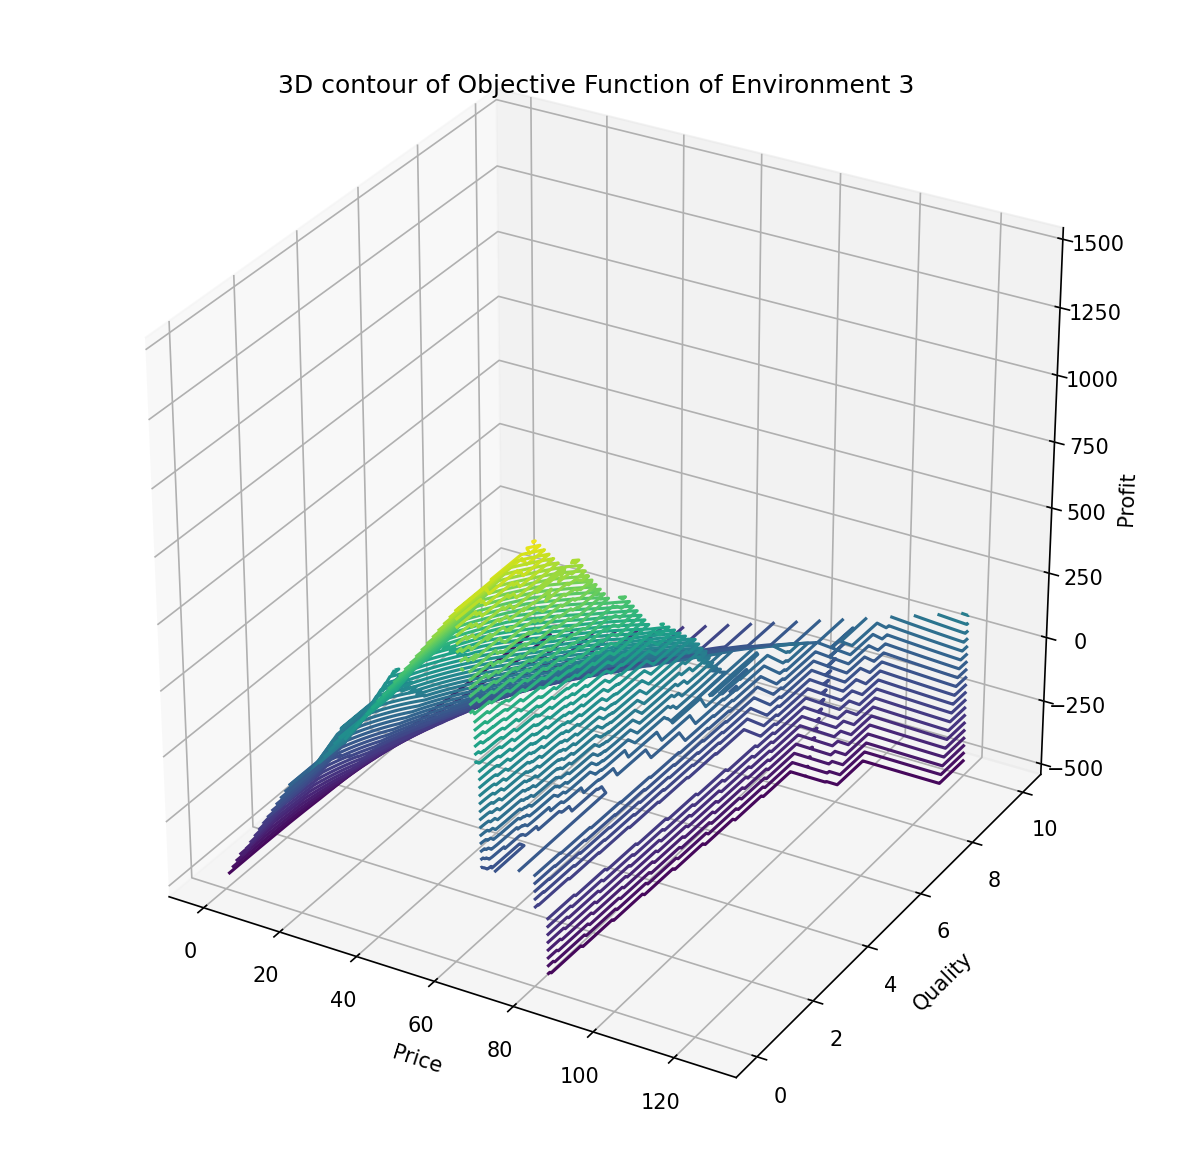

In [ ]:
for i in range(len(brute_PQL_history)):

    xyz_point = []
    for x in brute_PQL_history[i]:
        xyz_point.append(x.copy())

    for index1,a in enumerate(brute_Profit_history[i]):
        xyz_point[index1].append(a)
    xyz_table = pd.DataFrame(np.array(xyz_point),columns = ['x','y','z'])
    Z = xyz_table.pivot_table(index='x', columns='y', values='z').T.values
    X_unique = np.sort(xyz_table.x.unique())
    Y_unique = np.sort(xyz_table.y.unique())
    X, Y = np.meshgrid(X_unique, Y_unique)
    fig,ax=plt.subplots(1,1,figsize=(10,10),dpi = 150)
    cp = ax.contourf(X, Y, Z, levels = [-500,-375,-250,-125,0,125,250,375,500,625,750,875,1000,1125,1250,1375,1500])
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title(f'Filled contour of Objective Function of Environment {i+1}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Quality')
    plt.savefig(f"Filled contour env{i+1}.png", dpi=150)
    plt.show()
    fig = plt.figure(figsize=(10,10),dpi = 150)
    ax = plt.axes(projection='3d')
    ax.contour3D(X, Y, Z, 50)
    ax.set_zlim(-500,1500)
    ax.set_xlabel('Price')
    ax.set_ylabel('Quality')
    ax.set_zlabel('Profit')
    ax.set_title(f'3D contour of Objective Function of Environment {i+1}')
    plt.savefig(f"3D contour env{i+1}.png", dpi=150)
    plt.show()

# Expected Value Brute Force

In [ ]:
brute_price_limit = Budget_Range[0][1]
price_step = 0.1
brute_quality_limit = 10
quality_step = 1
brute_price_list  = []
brute_quality_list = []
price = 0
quality = 0
while True:
    brute_price_list.append(round(price,1))
    price += price_step 
    if price>brute_price_limit:
        break
while True:
    brute_quality_list.append(quality)
    quality += quality_step 
    if quality>brute_quality_limit:
        break
p = itertools.product(brute_price_list,brute_quality_list)
brute_PQL_list = [list(i) for i in p]
len(brute_PQL_list)
brute_EV_result = []
start = time.time()
print(f"Environment is being explored with {len(brute_PQL_list)} combinations")
for index,parameter in enumerate(brute_PQL_list):
    
    price = parameter[0]
    quality = round(parameter[1])
    expected_value = 0
    for env_index in range(len(Shop_Env)):
        Shop_List_Inloop = list(InitiateFocusedShop(Shop_Env[env_index],price,quality,Capital,CostAtQuality[env_index]))
        Simulate(Shop_List_Inloop,Customer_Env[env_index])
        expected_value += Shop_List_Inloop[5][-1] * env_prob[env_index]

    brute_EV_result.append(expected_value)

    if index % 1000 == 0:
        print(f"Index {index} Finished")

end = time.time()
print(f"Finished with {end-start} seconds taken")

Environment is being explored with 13871 combinations
Index 0 Finished
Index 1000 Finished
Index 2000 Finished
Index 3000 Finished
Index 4000 Finished
Index 5000 Finished
Index 6000 Finished
Index 7000 Finished
Index 8000 Finished
Index 9000 Finished
Index 10000 Finished
Index 11000 Finished
Index 12000 Finished
Index 13000 Finished
Finished with 119.98857736587524 seconds taken


In [ ]:
max_value = max(brute_EV_result)
max_index = brute_EV_result.index(max_value)
max_EV_price = brute_PQL_list[max_index][0]
max_EV_quality = brute_PQL_list[max_index][1]
print(f"Max Expected Value is {max_value} with price = {brute_PQL_list[max_index][0]} and quality = {brute_PQL_list[max_index][1]}")
env_profit = []
for env_index in range(len(Shop_Env)):
    price = max_EV_price
    quality = max_EV_quality
    Shop_List_Inloop = list(InitiateFocusedShop(Shop_Env[env_index],price,quality,Capital,CostAtQuality[env_index]))
    Simulate(Shop_List_Inloop,Customer_Env[env_index])
    print(f"Env{env_index+1} will get profit at {Shop_List_Inloop[5][-1]}")
    env_profit.append(Shop_List_Inloop[5][-1])


Max Expected Value is 86.1777777777778 with price = 119.9 and quality = 10
Env1 will get profit at 99.50000000000006
Env2 will get profit at -20.399999999999977
Env3 will get profit at 99.50000000000006
Env4 will get profit at 99.50000000000006
Env5 will get profit at 99.50000000000003
Env6 will get profit at 99.50000000000003
Env7 will get profit at 99.50000000000006
Env8 will get profit at 99.50000000000003
Env9 will get profit at 99.50000000000003


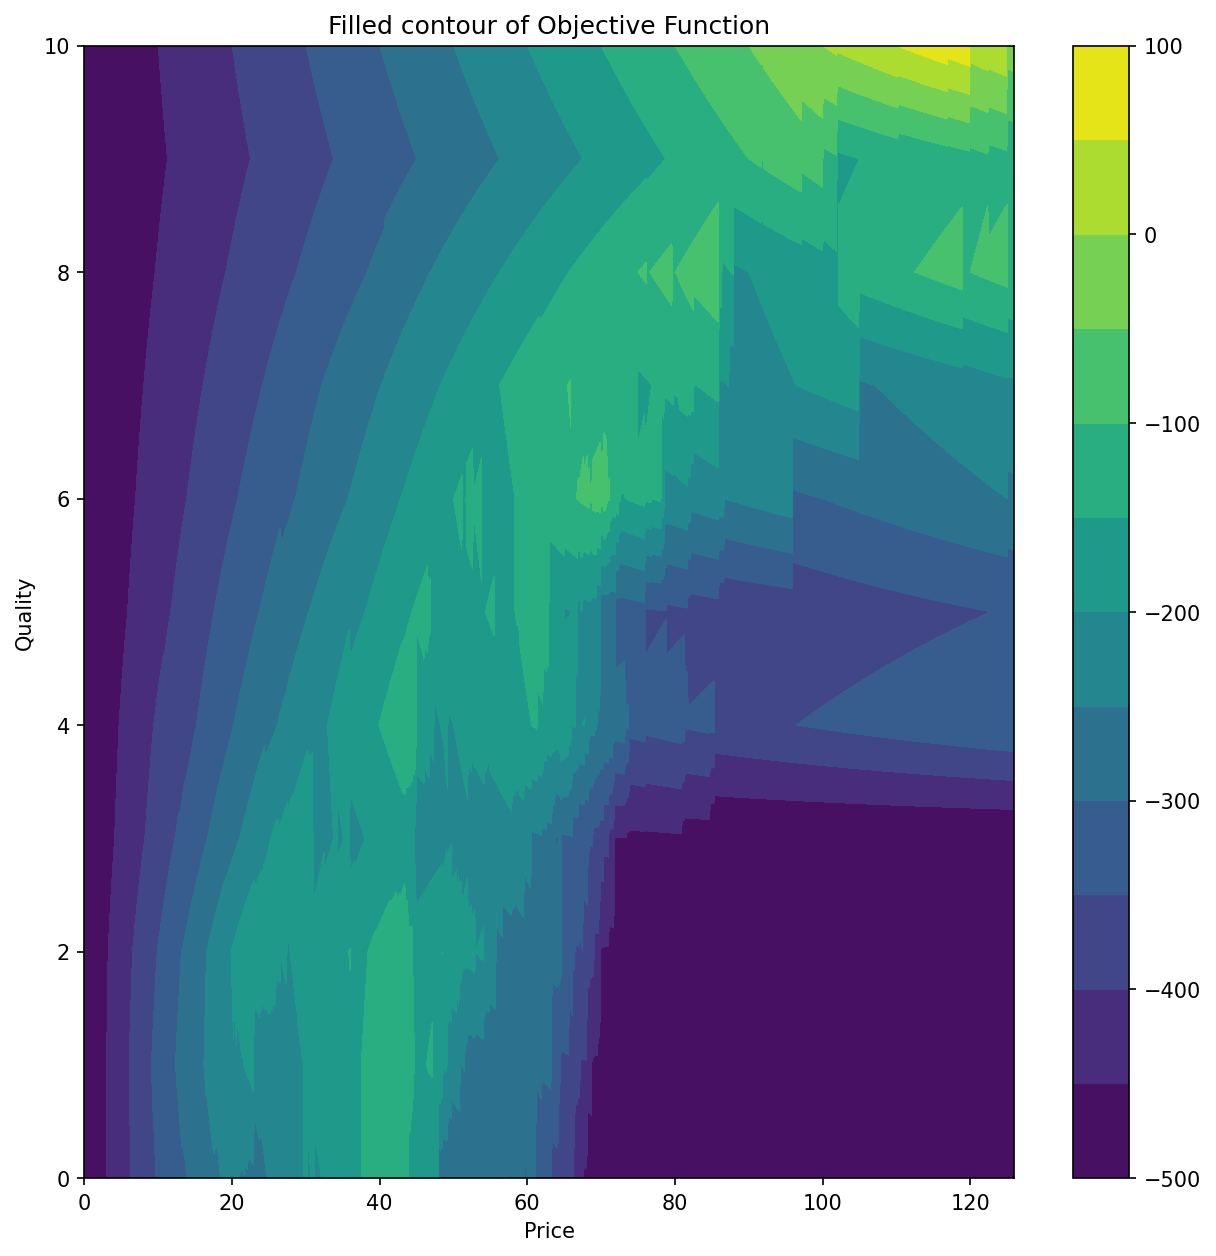

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


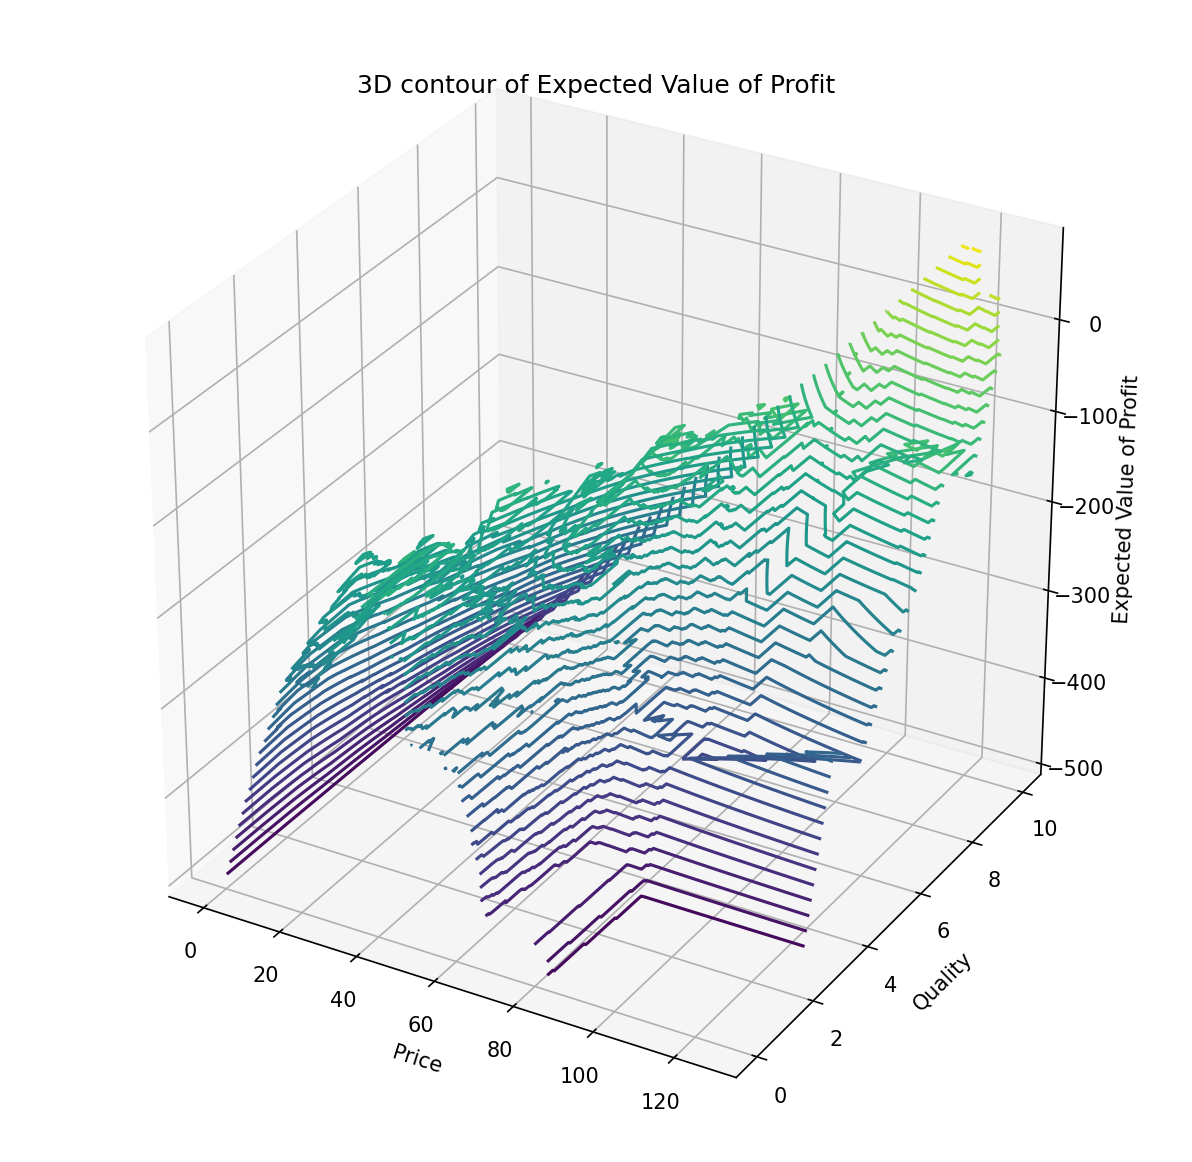

In [ ]:
xyz_point = [x.copy() for x in brute_PQL_list]

for i,a in enumerate(brute_EV_result):
    xyz_point[i].append(a)
xyz_table = pd.DataFrame(np.array(xyz_point),columns = ['x','y','z'])
Z = xyz_table.pivot_table(index='x', columns='y', values='z').T.values
X_unique = np.sort(xyz_table.x.unique())
Y_unique = np.sort(xyz_table.y.unique())
X, Y = np.meshgrid(X_unique, Y_unique)
fig,ax=plt.subplots(1,1,figsize=(10,10),dpi = 150)
Boole = True
j = -500
levels = []
levels.append(j)
while Boole:
    j += 50
    if j >= 100:
        Boole = False
    levels.append(j)
cp = ax.contourf(X, Y, Z, levels = levels)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled contour of Objective Function')
ax.set_xlabel('Price')
ax.set_ylabel('Quality')
plt.savefig("Filled contour of Expected Value of Profit.png", dpi=150)
plt.show()
fig = plt.figure(figsize=(10,10),dpi = 150)
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('Price')
ax.set_ylabel('Quality')
ax.set_zlabel('Expected Value of Profit')
ax.set_title('3D contour of Expected Value of Profit')
plt.savefig("3D contour.png", dpi=150)
plt.show()

# Expected Value Optimization with Cells Method

In [14]:
#การกำหนด Hyperr Parameter สำหรับการ Optimize

Generation = 30       #จะมีการปรับกี่ Generation
Pricelr = [25,10,5,1,0.1]             #lr จะปรับเมื่อเจอคำตอบซ้ำ ๆ 
Qualitylr = [1,1,1,1,1] 
             #จำนวนของร้านที่ดีที่สุดที่จะเลือก
param_lr = [Pricelr,Qualitylr]
opt = Optimization([3,1],2,[[0,Budget_Range[0][1]],[0,10]],param_lr)
#__init__(self,distribution_num,parameter_num,param_limit,param_lr)

In [15]:
runtime_his = []
contime_his = []
profit_his = []
for iteration in range(10):
    print(f"round {iteration+1}")
    init = opt.Initiate()
    MaxParam_History = []
    MaxPt_History = []
    MaxQ_History = []
    MaxPri_History = []
    duplication_count = 0
    start = time.time()
    end0 = []
    lr_index = 0
    stabilized_generation = Generation-1
    for gen in range(Generation):
        Best_Param_History = []
        param = opt.Breed(init,lr_index) 
        init_len = len(init)
        init = []
        Best_of_cell_History = []
        BestPt_of_cell_History = []
        for i in range(init_len):
            cell = param[i]
            Pt_List = []
            ParamHistory = []
            output = []
            for index,parameter in enumerate(cell):
                price = parameter[0]
                quality = round(parameter[1])
                expected_value = 0
                for env_index in range(len(Shop_Env)):
                    Shop_List_Inloop = list(InitiateFocusedShop(Shop_Env[env_index],price,quality,Capital,CostAtQuality[env_index]))
                    Simulate(Shop_List_Inloop,Customer_Env[env_index])
                    expected_value += Shop_List_Inloop[5][-1] * env_prob[env_index]

                Pt_List.append(expected_value)
                ParamHistory.append([x[-1] for x in Shop_List_Inloop])
                    
            Survived_index = Select(Pt_List,1)[0]
            Best_of_cell = ParamHistory[Survived_index]
            Best_Price = Best_of_cell[1]
            Best_Quality = Best_of_cell[2]
            Best_Pt = Pt_List[Survived_index]
            BestPt_of_cell_History.append(Best_Pt)
            Best_of_cell_History.append(Best_of_cell)
            init.append([Best_Price,Best_Quality])

        Pt_of_each_cell = []
        for pt in BestPt_of_cell_History:
            Pt_of_each_cell.append(pt)

        Best_index = Select(Pt_of_each_cell,1)[0]
        Best_of_gen_param = Best_of_cell_History[Best_index]
        MaxParam_History.append(Best_of_gen_param)
        MaxPri_History.append(Best_of_gen_param[1])
        MaxQ_History.append(Best_of_gen_param[2])
        MaxPt_History.append(Pt_of_each_cell[Best_index])

        if (gen+1)%5 == 0:
            print("Gen",gen+1,"has finished")
        if gen >= 2:
            if MaxPt_History[-1] == MaxPt_History[-2]:
                duplication_count += 1
            else :
                duplication_count = 0

            if duplication_count % 3 == 0 and duplication_count != 0:
                stabilized_generation = gen - duplication_count
                if lr_index < len(Pricelr)-1: 
                    lr_index += 1
                else:
                    lr_index = 0
        end0.append(time.time())

    end = time.time()
    print(f"Runtime of the program is {end - start}")
    print(f"Runtime Before Stable is {end0[stabilized_generation]-start}")
    print(f"Converged Generation is {stabilized_generation}")
    runtime_his.append(end - start)
    contime_his.append(end0[stabilized_generation]-start)
    profit_his.append(MaxPt_History[-1])
    

round 1
Gen 5 has finished
Gen 10 has finished
Gen 15 has finished
Gen 20 has finished
Gen 25 has finished
Gen 30 has finished
Runtime of the program is 4.46251916885376
Runtime Before Stable is 3.791630506515503
Converged Generation is 24
round 2
Gen 5 has finished
Gen 10 has finished
Gen 15 has finished
Gen 20 has finished
Gen 25 has finished
Gen 30 has finished
Runtime of the program is 5.277534484863281
Runtime Before Stable is 4.222428560256958
Converged Generation is 24
round 3
Gen 5 has finished
Gen 10 has finished
Gen 15 has finished
Gen 20 has finished
Gen 25 has finished
Gen 30 has finished
Runtime of the program is 4.95651388168335
Runtime Before Stable is 4.278896331787109
Converged Generation is 24
round 4
Gen 5 has finished
Gen 10 has finished
Gen 15 has finished
Gen 20 has finished
Gen 25 has finished
Gen 30 has finished
Runtime of the program is 4.4871766567230225
Runtime Before Stable is 3.7947373390197754
Converged Generation is 24
round 5
Gen 5 has finished
Gen 10 ha

In [16]:
runtime_his = np.array(runtime_his)
runtime_his = np.reshape(runtime_his,(runtime_his.size,-1))
contime_his = np.array(contime_his)
contime_his = np.reshape(contime_his,(contime_his.size,-1))
profit_his = np.array(profit_his)
profit_his = np.reshape(profit_his,(profit_his.size,-1))
result = np.concatenate((profit_his,runtime_his,contime_his),1)
Cells_result = pd.DataFrame(result,columns = ["Profit","Runtime","Converged Time"])

In [17]:
Cells_result.to_excel("Cells_result_Market.xlsx")

In [19]:
Cells_result

,Profit,Runtime,Converged Time
0,86.177778,4.462519,3.791631
1,86.177778,5.277534,4.222429
2,86.177778,4.956514,4.278896
3,86.177778,4.487177,3.794737
4,86.177778,4.493901,3.820000
5,86.177778,4.511952,3.820852
6,86.177778,4.559734,3.877739
7,86.177778,4.699844,4.029294
8,86.177778,4.500813,3.816730
9,86.177778,4.510869,3.831173


# Expected Value Optimization with Differential Evolution

In [20]:
def f(x):
    price = round(x[0],1)
    quality = round(x[1])
    expected_value = 0
    for env_index in range(len(Shop_Env)):
        Shop_List_Inloop = list(InitiateFocusedShop(Shop_Env[env_index],price,quality,Capital,CostAtQuality[env_index]))
        Simulate(Shop_List_Inloop,Customer_Env[env_index])
        expected_value += Shop_List_Inloop[5][-1] * env_prob[env_index]
    return -expected_value

In [26]:
from scipy.optimize import differential_evolution,dual_annealing
from numpy.random import rand
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
 
# objective function

 
# define range for input
pt_his = []
time_his = []

for i in range(10):
    bounds = [[0, 125], [0, 10]]
    start = time.time()
    result = differential_evolution(f, bounds, maxiter = 50)
    end = time.time()
    # summarize the result
    print('Status : %s' % result['message'])
    print('Total Evaluations: %d' % result['nfev'])
    # evaluate solution
    solution = result['x']
    evaluation = -f(solution)
    print('Solution: f(%s) = %.5f' % (solution, evaluation))
    pt_his.append(evaluation)
    time_his.append(end-start)
    print(f"round {i+1} with {end-start} sec")

Status : Optimization terminated successfully.
Total Evaluations: 573
Solution: f([119.89261952   9.81486466]) = 86.17778
round 1 with 5.078574895858765 sec
Status : Optimization terminated successfully.
Total Evaluations: 753
Solution: f([119.89985389   9.51142552]) = 86.17778
round 2 with 6.622392892837524 sec
Status : Optimization terminated successfully.
Total Evaluations: 573
Solution: f([119.93005818   9.61081336]) = 86.17778
round 3 with 5.0513269901275635 sec
Status : Optimization terminated successfully.
Total Evaluations: 843
Solution: f([119.86980849   9.55844167]) = 86.17778
round 4 with 7.449159860610962 sec
Status : Optimization terminated successfully.
Total Evaluations: 783
Solution: f([119.87692465   9.60205459]) = 86.17778
round 5 with 6.944623231887817 sec
Status : Optimization terminated successfully.
Total Evaluations: 693
Solution: f([119.91016839   9.73515607]) = 86.17778
round 6 with 6.173869848251343 sec
Status : Optimization terminated successfully.
Total Eval

In [27]:
time_array = np.reshape(np.array(time_his),(np.array(time_his).size,-1))
pt_array = np.reshape(np.array(pt_his),(np.array(pt_his).size,-1))

In [28]:
Dif_evo = pd.DataFrame(np.concatenate((pt_array,time_array),1),columns=["Profit","Time"])

In [29]:
Dif_evo.to_excel("Dif_evo.xlsx")

In [30]:
Dif_evo

,Profit,Time
0,86.177778,5.078575
1,86.177778,6.622393
2,86.177778,5.051327
3,86.177778,7.449160
4,86.177778,6.944623
5,86.177778,6.173870
6,86.177778,5.387842
7,86.177778,6.406186
8,86.177778,6.138827
9,86.177778,6.188864


# Expected Value Optimization with Dual Annealing

In [ ]:
def f(x):
    price = round(x[0],1)
    quality = round(x[1])
    expected_value = 0
    for env_index in range(len(Shop_Env)):
        Shop_List_Inloop = list(InitiateFocusedShop(Shop_Env[env_index],price,quality,Capital,CostAtQuality[env_index]))
        Simulate(Shop_List_Inloop,Customer_Env[env_index])
        expected_value += Shop_List_Inloop[5][-1] * env_prob[env_index]
    return -expected_value

In [ ]:
from scipy.optimize import differential_evolution,dual_annealing
from numpy.random import rand
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
 
# objective function

 
# define range for input
pt_his = []
time_his = []

for i in range(10):
    bounds = [[0, 125], [0, 10]]
    start = time.time()
    result = dual_annealing(f, bounds)
    end = time.time()
    # summarize the result
    print('Status : %s' % result['message'])
    print('Total Evaluations: %d' % result['nfev'])
    # evaluate solution
    solution = result['x']
    evaluation = -f(solution)
    print('Solution: f(%s) = %.5f' % (solution, evaluation))
    pt_his.append(evaluation)
    time_his.append(end-start)
    print(f"round {i+1} with {end-start} sec")

Status : ['Maximum number of iteration reached']
Total Evaluations: 4019
Solution: f([119.89300585   9.61449385]) = 86.17778
round 1 with 37.58300805091858 sec
Status : ['Maximum number of iteration reached']
Total Evaluations: 4016
Solution: f([119.90362276   9.87685333]) = 86.17778
round 2 with 35.37432098388672 sec
Status : ['Maximum number of iteration reached']
Total Evaluations: 4019
Solution: f([119.89879076   9.66594897]) = 86.17778
round 3 with 35.47813844680786 sec
Status : ['Maximum number of iteration reached']
Total Evaluations: 4034
Solution: f([119.92002701   9.97986082]) = 86.17778
round 4 with 35.6132287979126 sec
Status : ['Maximum number of iteration reached']
Total Evaluations: 4025
Solution: f([119.90773114   9.79885058]) = 86.17778
round 5 with 35.53216743469238 sec
Status : ['Maximum number of iteration reached']
Total Evaluations: 4025
Solution: f([119.93374329   9.54495311]) = 86.17778
round 6 with 35.4673125743866 sec
Status : ['Maximum number of iteration rea

In [ ]:
time_array = np.reshape(np.array(time_his),(np.array(time_his).size,-1))
pt_array = np.reshape(np.array(pt_his),(np.array(pt_his).size,-1))

In [ ]:
Dual_ANN = pd.DataFrame(np.concatenate((pt_array,time_array),1),columns=["Profit","Time"])

In [ ]:
Dual_ANN.to_excel("Dual_Annealing_Result.xlsx")

In [ ]:
Dual_ANN